In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from Helper.ImportDatasetsFairness import df_epsilon, df_epsilon_crit, networks
from Helper.NonParametric import get_quantile, get_quantile_fairness


In [ ]:
crit_epsilons_network = {}

for network in networks:
    # Take all critical epsilons of the test set and put into numpy array
    df_for_network = df_epsilon_crit[df_epsilon_crit['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    df_for_network = df_for_network.dropna() # Drop NaN values
    crit_epsilons_network[network] = df_for_network['Epsilon'].to_numpy()


In [ ]:
# two plots next to each other
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

x1 = np.sort(crit_epsilons)
y1 = np.arange(len(x1))/float(len(x1))
axs[0].plot(x1, y1, label='Default')

x2 = np.sort(np.log(crit_epsilons))
y2 = np.arange(len(x2))/float(len(x2))
axs[1].plot(x2, y2, label='Log')

plt.show()

In [ ]:
# Do this for all 3 networks so that the plots are on top of each other
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i, network in enumerate(networks):
    x1 = np.sort(crit_epsilons_network[network])
    y1 = np.arange(len(x1))/float(len(x1))
    axs[i, 0].plot(x1, y1, label='Default ' + network)

    x2 = np.sort(np.log(crit_epsilons_network[network]))
    y2 = np.arange(len(x2))/float(len(x2))
    axs[i, 1].plot(x2, y2, label='Log ' + network)
    axs[i, 0].legend()
    axs[i, 1].legend()


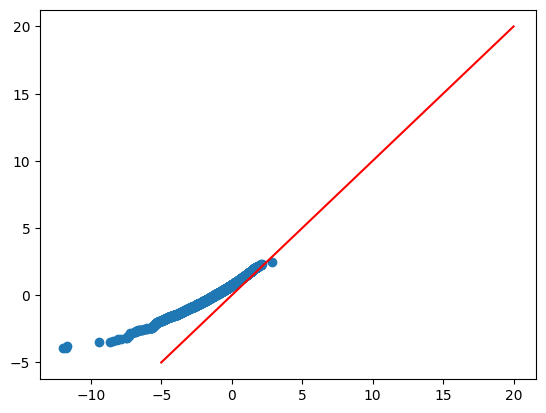

In [12]:
# take random samples from gamma distribution
from scipy.stats import gamma

gamma1 = gamma.rvs(a=1, size=10000)
gamma1 = np.sort(np.log(gamma1))
gamma2 = gamma.rvs(a=2, size=10000)
gamma2 = np.sort(np.log(gamma2))

plt.scatter(gamma1, gamma2)

# plot diagonal line
x = np.linspace(-5, 20, 100)
plt.plot(x, x, color='red')

In [ ]:
# Q-Q plot
# take random samples from normal distribution
norm = np.random.lognormal(0, 1, 10000)
norm.sort()

norm2 = np.random.lognormal(50, 1000, 10000)
norm2.sort()

plt.scatter(np.log(norm), np.log(norm2))

# plot diagonal line
x = np.linspace(-5, 5, 100)
plt.plot(x, x, color='red')

In [ ]:
# split crit epsilon in things of 200 and then see the quantiles

for i in range(10):
    print(get_quantile(crit_epsilons[(i)*100:(i+1)*100], 0.05, verbose=True))

In [ ]:
get_quantile(crit_epsilons, 0.05)

In [ ]:
# sample a log normal 10000 times
log_normal = np.random.lognormal(0, 1, 10000000)

In [ ]:
# plot empirical cdf
x = np.sort(np.log(log_normal))
y = np.arange(len(x))/float(len(x))
plt.plot(x, y)
